# 검증 세트
- 테스트 세트를 사용해 자꾸 성능을 확인하다 보면 점점 테스트 세트에 맞추게 됨
- 20%를 테스트, 20%를 검증, 60% 훈련

In [ ]:
import pandas as pd
wine = pd.read_csv('https://bit.ly/wine_csv_data')

In [ ]:
data = wine[['alcohol','sugar','pH']].to_numpy()
target = wine['class'].to_numpy()

In [ ]:
from sklearn.model_selection import train_test_split
train_input, test_input, train_target, test_target = train_test_split(data, target, test_size = 0.2, random_state=42)
sub_input, val_input, sub_target, val_target = train_test_split(train_input, train_target, test_size = 0.2, random_state=42)

In [ ]:
print(sub_input.shape, val_input.shape)

(4157, 3) (1040, 3)


In [ ]:
from sklearn.tree import DecisionTreeClassifier
dt = DecisionTreeClassifier(random_state=42)
dt.fit(sub_input,sub_target)
print(dt.score(sub_input,sub_target))
print(dt.score(val_input,val_target))

0.9971133028626413
0.864423076923077


- 과대 적합일 가능성이 있음

# 교차 검증
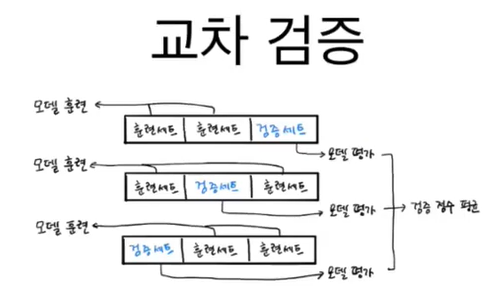

- 위 그림은 3-폴드 교차 검증
- 교차 검증을 이용하여 안정적인 검증 점수를 얻고 훈련에 더 많은 데이터를 사용할 수 있음

In [ ]:
from sklearn.model_selection import cross_validate
scores = cross_validate(dt, train_input, train_target)
print(scores)

{'fit_time': array([0.01147437, 0.01019359, 0.01345921, 0.01073623, 0.01041079]), 'score_time': array([0.0012958 , 0.00125742, 0.00120807, 0.00103784, 0.00111318]), 'test_score': array([0.86923077, 0.84615385, 0.87680462, 0.84889317, 0.83541867])}


In [ ]:
import numpy as np
print(np.mean(scores['test_score']))

0.855300214703487


- cross_validate()는 훈련 세트를 섞어 폴드를 나누지 않음
- 훈련 세트르 준비했기 때문에 따로 섞을 필요가 없음
- 훈련 세트를 섞으려면 분할기를 지정해야 함

In [ ]:
from sklearn.model_selection import StratifiedKFold
scores = cross_validate(dt, train_input, train_target, cv=StratifiedKFold())
print(np.mean(scores['test_score']))

0.855300214703487


- 만약 훈련 세트를 섞은 후 10-폴드 교차 검증을 수행하려면 다음과 같이 작성함

In [ ]:
splitter = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
scores = cross_validate(dt, train_input, train_target, cv=splitter)
print(np.mean(scores['test_score']))

0.8574181117533719


# 하이퍼파라미터 튜닝
- 모델이 학습할 수 없어서 사용자가 지정해야만 하는 파라미터

- **그리드 서치** 사용함
- 하이퍼파라미터 탐색과 교차 검증을 한 번에 수행함
  - cross_validate를 호출할 필요가 없음
  

In [ ]:
from sklearn.model_selection import GridSearchCV
params = {'min_impurity_decrease' : [0.0001, 0.0002, 0.0003, 0.0004, 0.0005]}
gs = GridSearchCV(DecisionTreeClassifier(random_state=42), params, n_jobs=-1)
# n_jobs는 병렬 실행에 사용할 CPU 코어 수
# 기본값은 1이나 -1로 지정하면 시스템에 있는 모든 코어 사용함

In [ ]:
gs.fit(train_input, train_target)

GridSearchCV(estimator=DecisionTreeClassifier(random_state=42), n_jobs=-1,
             param_grid={'min_impurity_decrease': [0.0001, 0.0002, 0.0003,
                                                   0.0004, 0.0005]})

- 사이킷런의 그리드 서치는 훈련이 끝나면 25개의 모델 중에서 검증 점수가 가장 높은 모델의 매개변수 조합으로 전체 훈련 세트에서 자동으로 다시 모델을 훈련함

In [ ]:
dt = gs.best_estimator_
print(dt.score(train_input, train_target))

0.9615162593804117


- 그리드 서치로 찾은 최적의 매개변수는 best_params_ 속성에 저장되어 있음

In [ ]:
print(gs.best_params_)

{'min_impurity_decrease': 0.0001}


In [ ]:
print(gs.cv_results_['mean_test_score'])

[0.86819297 0.86453617 0.86492226 0.86780891 0.86761605]


In [ ]:
print(gs.cv_results_)

{'mean_fit_time': array([0.01478982, 0.01506329, 0.01427412, 0.01279168, 0.00939026]), 'std_fit_time': array([0.00377423, 0.00234119, 0.00233259, 0.00367509, 0.00330788]), 'mean_score_time': array([0.00119309, 0.00163565, 0.00109015, 0.00215807, 0.00430837]), 'std_score_time': array([5.17546056e-05, 1.05024995e-03, 3.98621605e-05, 2.10713700e-03,
       6.55360910e-03]), 'param_min_impurity_decrease': masked_array(data=[0.0001, 0.0002, 0.0003, 0.0004, 0.0005],
             mask=[False, False, False, False, False],
       fill_value='?',
            dtype=object), 'params': [{'min_impurity_decrease': 0.0001}, {'min_impurity_decrease': 0.0002}, {'min_impurity_decrease': 0.0003}, {'min_impurity_decrease': 0.0004}, {'min_impurity_decrease': 0.0005}], 'split0_test_score': array([0.86923077, 0.87115385, 0.86923077, 0.86923077, 0.86538462]), 'split1_test_score': array([0.86826923, 0.86346154, 0.85961538, 0.86346154, 0.86923077]), 'split2_test_score': array([0.8825794 , 0.87680462, 0.87584216,

In [ ]:
best_index = np.argmax(gs.cv_results_['mean_test_score'])
print(gs.cv_results_['params'][best_index])

{'min_impurity_decrease': 0.0001}


- min_samples_split으로 노드를 나누기 위한 최소 샘플 수를 결정

In [ ]:
params = {'min_impurity_decrease' : np.arange(0.0001, 0.001, 0.0001), 
          'max_depth' : range(5, 20, 1),
          'min_samples_split' : range(2, 100, 10)}

In [ ]:
np.arange(0.0001, 0.001, 0.0001)

array([0.0001, 0.0002, 0.0003, 0.0004, 0.0005, 0.0006, 0.0007, 0.0008,
       0.0009])

In [ ]:
range(5, 20, 1)

range(5, 20)

- 이 매개변수로 수행할 교차 검증 횟수는 9 x 15 x 10 = 1,350개
- 5-폴드 교차 검증을 수행하므로 만들어지는 모델의 수는 6,750개나 됨
- n_jobs 매개변수를 -1로 설정하고 그리드 서치를 실행하겠음

In [ ]:
gs = GridSearchCV(DecisionTreeClassifier(random_state=42), params, n_jobs=-1)
gs.fit(train_input, train_target)

GridSearchCV(estimator=DecisionTreeClassifier(random_state=42), n_jobs=-1,
             param_grid={'max_depth': range(5, 20),
                         'min_impurity_decrease': array([0.0001, 0.0002, 0.0003, 0.0004, 0.0005, 0.0006, 0.0007, 0.0008,
       0.0009]),
                         'min_samples_split': range(2, 100, 10)})

In [ ]:
print(gs.best_params_)

{'max_depth': 14, 'min_impurity_decrease': 0.0004, 'min_samples_split': 12}


In [ ]:
print(np.max(gs.cv_results_['mean_test_score']))

0.8683865773302731


- **랜덤 서치**
- 매개변수의 값이 수치일 때 값의 범위나 간격을 미리 정하기 어려움
- 매개변수도 많아서 시간이 오래걸림
- 하지만 랜덤 서치로 매개변수를 샘플링할 수 있는 확류 분포객체를 전달함

In [ ]:
from scipy.stats import uniform, randint
rgen = randint(0, 10)
rgen.rvs(10)

array([3, 9, 2, 8, 7, 5, 1, 3, 2, 6])

- 고르게 값을 뽑음

In [ ]:
np.unique(rgen.rvs(1000), return_counts=True)

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]),
 array([ 89, 115, 106,  91,  90,  94, 104, 100, 110, 101]))

- 1000개를 뽑아서 그 개수를 셈

In [ ]:
ugen = uniform(0, 1)
ugen.rvs(10)

array([0.40449559, 0.41745313, 0.02285739, 0.91854097, 0.96569519,
       0.88371976, 0.54558931, 0.825777  , 0.326781  , 0.24346036])

- 랜덤하게 샘플링 하여 그리드 서치 가능해짐

In [ ]:
params = {'min_impurity_decrease' : uniform(0.0001, 0.001),
          'max_depth' : randint(20, 50),
          'min_samples_split' : randint(2, 25),
          'min_samples_leaf' : randint(1, 25),}

In [ ]:
from sklearn.model_selection import RandomizedSearchCV
gs = RandomizedSearchCV(DecisionTreeClassifier(random_state=42), params, 
                        n_iter=100, n_jobs=-1, random_state=42)
gs.fit(train_input, train_target)

RandomizedSearchCV(estimator=DecisionTreeClassifier(random_state=42),
                   n_iter=100, n_jobs=-1,
                   param_distributions={'max_depth': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7f7aa70a2750>,
                                        'min_impurity_decrease': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7f7aa70a21d0>,
                                        'min_samples_leaf': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7f7aa7181b50>,
                                        'min_samples_split': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7f7aa70a2c50>},
                   random_state=42)

In [ ]:
params = {'min_impurity_decrease' : uniform(0.0001, 0.001),
          'max_depth' : randint(20, 50),
          'min_samples_split' : randint(2, 25),
          'min_samples_leaf' : randint(1, 25)}
from sklearn.model_selection import RandomizedSearchCV
gs = RandomizedSearchCV(DecisionTreeClassifier(random_state=42), params, 
                        n_iter=100, n_jobs=-1, random_state=42)
gs.fit(train_input, train_target)

RandomizedSearchCV(estimator=DecisionTreeClassifier(random_state=42),
                   n_iter=100, n_jobs=-1,
                   param_distributions={'max_depth': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7f7aa7015cd0>,
                                        'min_impurity_decrease': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7f7aa7047a50>,
                                        'min_samples_leaf': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7f7aa72ce7d0>,
                                        'min_samples_split': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7f7aa7015510>},
                   random_state=42)

- 샘플링 횟수를 n_iter로 결정할 수 있음

In [ ]:
print(gs.best_params_)

{'max_depth': 39, 'min_impurity_decrease': 0.00034102546602601173, 'min_samples_leaf': 7, 'min_samples_split': 13}


In [ ]:
print(np.max(gs.cv_results_['mean_test_score']))

0.8695428296438884


In [ ]:
dt = gs.best_estimator_
print(dt.score(test_input, test_target))

0.86
